In [1]:
import sys
import os
import os.path as osp

sys.path.insert(0, "../utils/")
sys.path.insert(0, "../")


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2

In [3]:
def image_show(image, figsize=(7, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, interpolation='nearest')
    plt.tight_layout()
    plt.show()

    
def image_keypoints_show(image_tensor, keypoints,figsize=(7, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    img = image_tensor.numpy().transpose((1, 2, 0))
    ax.imshow(img, interpolation='nearest')

    for i in range(keypoints.shape[1]):
        kp = keypoints[0, i, :]
        if kp[0]>0:
            ax.plot(kp[0], kp[1], marker='o', color="blue", markersize=10)

    plt.tight_layout()
    plt.show()
    
def image_grid_show(image_stack, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                    )
    stack_indices = [i for i in range(image_stack.shape[0])]
    for ax, im_idx in zip(grid, stack_indices):
        ax.imshow(image_stack[im_idx])
    plt.show()

# Configuration file parser

In [4]:
from utils.read_config import yaml_to_object

In [5]:
config = yaml_to_object("./../config.yaml")

root_dir = osp.abspath(osp.dirname("."))

setattr(config, "root_dir", osp.dirname(root_dir))

# MPIIAnnotationHandler

In [6]:
from utils.annotation_handler import MPIIAnnotationHandler

In [7]:
data_path = osp.join(config.root_dir, config.data.MPII.path.base)
training_annotation_file = osp.join(data_path, config.data.MPII.path.annotations.training)
validation_annotation_file = osp.join(data_path, config.data.MPII.path.annotations.validation)
image_dir = osp.join(data_path, config.data.MPII.path.images)

In [8]:
dh = MPIIAnnotationHandler(training_annotation_file, validation_annotation_file, image_dir)

Loading annotation data...
Done! (t=3.47s)


In [9]:
image_path, keypoints, center, scale = dh[0]
print(f"image_path: {image_path}")
print(f"center: {center}")
print(f"scale: {scale}\n")
print(f"keypoints:\n{keypoints}")

image_path: /home/adi/git_clones/torch_shnet/data/MPII/images/015601864.jpg
center: [594.         302.31569265]
scale: 3.7763077205121935

keypoints:
[[[620. 394.   1.]
  [616. 269.   1.]
  [573. 185.   1.]
  [647. 188.   0.]
  [661. 221.   1.]
  [656. 231.   1.]
  [610. 187.   0.]
  [647. 176.   1.]
  [637. 189.   1.]
  [695. 108.   1.]
  [606. 217.   1.]
  [553. 161.   1.]
  [601. 167.   1.]
  [692. 185.   1.]
  [693. 240.   1.]
  [688. 313.   1.]]]


In [10]:
train_indices, valid_indices = dh.split_data()
print(f"train_indices.shape: {train_indices.shape}")
print(f"valid_indices.shape: {valid_indices.shape}")

train_indices.shape: (22246,)
valid_indices.shape: (2958,)


# MPIIDataset

In [11]:
from utils.dataset import MPIIDataset

In [12]:
train_dataset = MPIIDataset(
    indices=train_indices,
    mpii_annotation_handle=dh,
    horizontally_flipped_keypoint_ids=config.data.MPII.parts.flipped_ids,
    input_resolution=config.neural_network.train.input_resolution,
    output_resolution=config.neural_network.train.output_resolution,
    num_parts=config.data.MPII.parts.max_count,
    reference_image_size=config.data.MPII.reference_image_size,
    max_rotation_angle=config.neural_network.train.data_augmentation.rotation_angle_max,
    image_scale_factor_range=(config.neural_network.train.data_augmentation.image_scale_factor.min, config.neural_network.train.data_augmentation.image_scale_factor.max),
    image_color_jitter_probability=config.neural_network.train.data_augmentation.image_color_jitter_probability,
    image_horizontal_flip_probability=config.neural_network.train.data_augmentation.image_horizontal_flip_probability,
    hue_max_delta=config.neural_network.train.data_augmentation.hue_max_delta,
    saturation_min_delta=config.neural_network.train.data_augmentation.saturation_min_delta,
    brightness_max_delta=config.neural_network.train.data_augmentation.brightness_max_delta,
    contrast_min_delta=config.neural_network.train.data_augmentation.contrast_min_delta,
)

valid_dataset = MPIIDataset(
    indices=valid_indices,
    mpii_annotation_handle=dh,
    horizontally_flipped_keypoint_ids=config.data.MPII.parts.flipped_ids,
    input_resolution=config.neural_network.train.input_resolution,
    output_resolution=config.neural_network.train.output_resolution,
    num_parts=config.data.MPII.parts.max_count,
    reference_image_size=config.data.MPII.reference_image_size,
    max_rotation_angle=config.neural_network.train.data_augmentation.rotation_angle_max,
    image_scale_factor_range=(config.neural_network.train.data_augmentation.image_scale_factor.min, config.neural_network.train.data_augmentation.image_scale_factor.max),
    image_color_jitter_probability=config.neural_network.train.data_augmentation.image_color_jitter_probability,
    image_horizontal_flip_probability=config.neural_network.train.data_augmentation.image_horizontal_flip_probability,
    hue_max_delta=config.neural_network.train.data_augmentation.hue_max_delta,
    saturation_min_delta=config.neural_network.train.data_augmentation.saturation_min_delta,
    brightness_max_delta=config.neural_network.train.data_augmentation.brightness_max_delta,
    contrast_min_delta=config.neural_network.train.data_augmentation.contrast_min_delta
)


I am hear!!
image_tensor.shape: torch.Size([3, 256, 256])


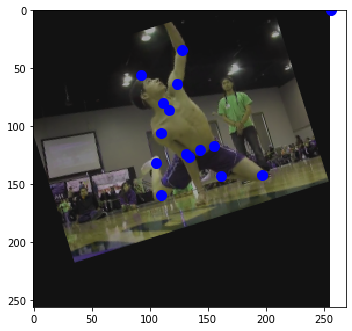

In [13]:
np.random.seed(100)
idxs = np.random.randint(0, 6000, size=(100,))
idxs = [3000]
for idx in idxs:
    image_tensor, heatmap, in_kps, out_kps = train_dataset[idx]
    print(f"image_tensor.shape: {image_tensor.shape}")
    image_keypoints_show(image_tensor, out_kps, figsize=(5, 5))


In [14]:
out_kps, in_kps

(array([[[105.51497082, 131.42021537,   1.        ],
         [109.72181355, 159.31259978,   1.        ],
         [131.4569233 , 124.0646457 ,   0.        ],
         [155.68765935, 117.25648789,   1.        ],
         [196.58218417, 141.90110909,   1.        ],
         [161.05830665, 142.89024401,   1.        ],
         [143.43543836, 120.23276268,   0.        ],
         [116.29962589,  85.52778544,   1.        ],
         [111.5431538 ,  79.50403749,   1.        ],
         [ 92.51726543,  55.40904565,   1.        ],
         [  0.        ,   0.        ,   1.        ],
         [133.98925753, 126.08405849,   1.        ],
         [109.52152349, 105.6162246 ,   1.        ],
         [123.38592464,  63.45442392,   1.        ],
         [128.00887003,  33.68058842,   1.        ],
         [256.        ,   0.        ,   0.        ]]]),
 array([[[105.51497082, 131.42021537,   1.        ],
         [109.72181355, 159.31259978,   1.        ],
         [131.4569233 , 124.0646457 ,   0. 

heatmap.shape: torch.Size([16, 256, 256])


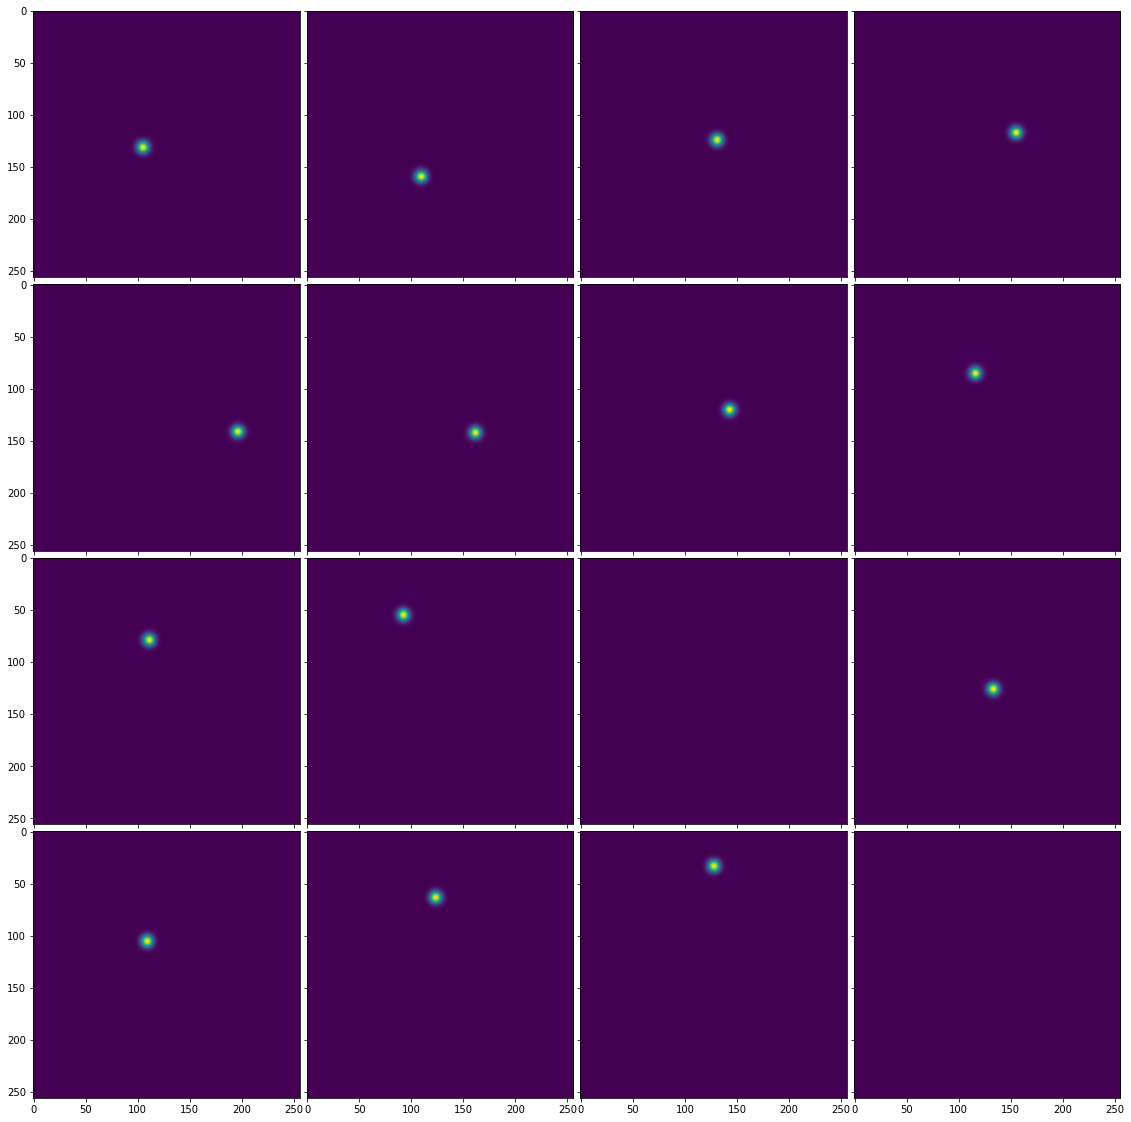

In [15]:
print(f"heatmap.shape: {heatmap.shape}")
image_grid_show(heatmap.numpy(), figsize=(20, 20))

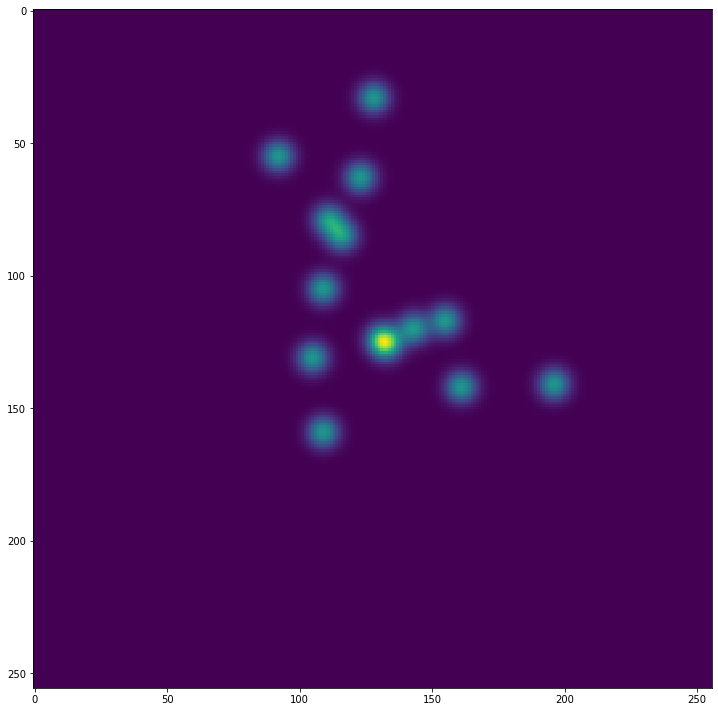

In [16]:
image_show(torch.sum(heatmap, axis=0).numpy(), figsize=(10, 10))